In [1]:
import numpy as np
import skimage as sk
import skimage.io as skio
import skimage.color as color
from numpy import newaxis
import cv2 as cv
import imutils
import scipy
from numpy import asarray
from scipy import signal
import matplotlib.pyplot as plt
from skimage.draw import polygon
from scipy.spatial import Delaunay
from scipy import interpolate
from moviepy.editor import ImageSequenceClip
import glob, os

Project 3: Face Morphing

In [2]:
# Part 1: Defining Correspondences

imname1 = 'images/george.png'
imname2 = 'images/sophia.png'
suni = sk.img_as_float(skio.imread(imname1))[:, :, :3]
sophia = sk.img_as_float(skio.imread(imname2))[:, :, :3]
suni = suni[0:1212,0:870]

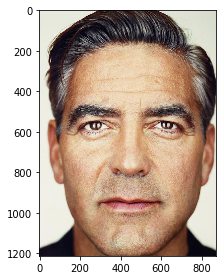

In [3]:
skio.imshow(suni)

In [6]:
%matplotlib qt
skio.imshow(suni)
#suni_points = plt.ginput(n=29, timeout=90, show_clicks=True)

In [4]:
suni_points = np.array([(227.18774488690775, 228.84630929033528),
 (466.1727056422781, 162.62156112920866),
 (699.3989926445072, 231.72564616690602),
 (777.1410883119167, 410.244532514291),
 (803.0551202010533, 568.6080607256808),
 (797.2964464479119, 764.4029683324902),
 (765.6237408056338, 954.4392021861581),
 (659.0882763725169, 1109.9233935209772),
 (443.13801062971237, 1202.0621735712405),
 (227.18774488690775, 1089.7680353849823),
 (146.56631234292746, 963.0772128158703),
 (123.5316173303616, 767.282305209061),
 (109.13493294750793, 574.3667344788223),
 (146.56631234292746, 404.48585876114953),
 (207.03238675091274, 588.763418861676),
 (359.63724120916123, 580.1254082319638),
 (541.0354644331171, 585.8840819851052),
 (713.7956770273606, 591.6427557382467),
 (350.99923057944903, 775.9203158387731),
 (448.8966843828537, 744.2476101964952),
 (541.0354644331171, 781.6789895919146),
 (302.0505036777467, 951.5598653095874),
 (440.25867375314164, 934.283844050163),
 (595.7428650879608, 948.6805284330167),
 (443.13801062971237, 988.9912447050068),
 (-0.2798683621796272, 1.3786960412478493),
 (857.762520855897, 4.258032917818582),
 (860.6418577324678, 1202.0621735712405),
 (11.237479144103247, 1196.303499818099)])

In [8]:
%matplotlib qt
skio.imshow(sophia)
# sophia_points = plt.ginput(n=29, timeout=100, show_clicks=True)

In [5]:
sophia_points = np.array([(230.06708176347848, 191.41492989491576),
 (440.25867375314164, 125.19018173378913),
 (636.0535813599511, 220.2082986606231),
 (728.1923614102143, 367.0544793657301),
 (751.2270564227802, 539.8146919599736),
 (754.1063932993509, 744.2476101964952),
 (716.6750139039314, 899.7318015313143),
 (598.6222019645315, 1017.784613470714),
 (402.8272943577221, 1132.958088533543),
 (227.18774488690775, 1012.0259397175727),
 (112.01426982407867, 882.45578027189),
 (94.73824856465438, 735.609599566783),
 (97.61758544122512, 539.8146919599736),
 (120.65228045379087, 352.65779498287645),
 (172.48034423206394, 551.3320394662566),
 (319.3265249371711, 559.9700500959688),
 (520.880106297122, 559.9700500959688),
 (679.2436345085121, 559.9700500959688),
 (307.80917743088816, 770.1616420856317),
 (411.4653049874343, 732.7302626902123),
 (518.0007694205513, 767.282305209061),
 (267.498461158898, 896.8524646547436),
 (417.2239787405758, 885.3351171484608),
 (558.3114856925415, 893.973127778173),
 (414.34464186400504, 986.1119078284362),
 (11.237479144103247, 7.137369794389315),
 (854.8831839793263, 10.016706670960048),
 (854.8831839793263, 1196.303499818099),
 (11.237479144103247, 1196.303499818099)])

In [6]:
mean_points = (np.array(suni_points) + np.array(sophia_points)) / 2.0

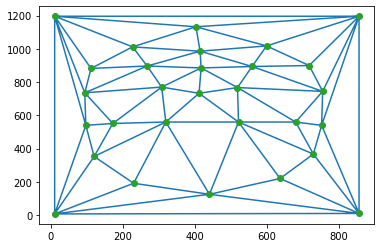

In [7]:
tri = Delaunay(mean_points)
plt.triplot(sophia_points[:,0], sophia_points[:,1], tri.simplices)
plt.plot(sophia_points[:,0], sophia_points[:,1], 'o')
plt.show()

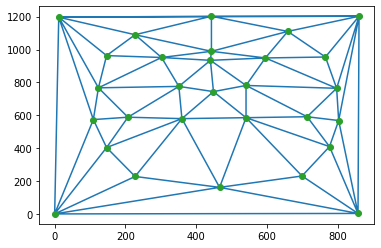

In [8]:
tri = Delaunay(mean_points)
plt.triplot(suni_points[:,0], suni_points[:,1], tri.simplices)
plt.plot(suni_points[:,0], suni_points[:,1], 'o')
plt.show()

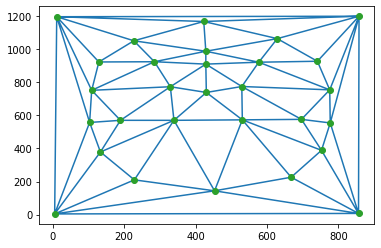

In [9]:
tri = Delaunay(mean_points)
plt.triplot(mean_points[:,0], mean_points[:,1], tri.simplices)
plt.plot(mean_points[:,0], mean_points[:,1], 'o')
plt.show()

In [38]:
# Part 2: Computing the Midway Face

In [10]:
def computeAffine(tri1_pts, tri2_pts):
    "Returns Affine Matrix"
    
    tri1 = np.vstack((tri1_pts.T, np.ones((1, 3))))
    tri2 = np.vstack((tri2_pts.T, np.ones((1, 3))))
    
    inv = np.linalg.inv(tri1)
    T = np.dot(tri2, inv)
    return T

In [33]:
def inverse_warp(src, src_pts, target_pts, tri):
            
    interp_b = interpolate.RectBivariateSpline(np.arange(src.shape[0]), np.arange(src.shape[1]), src[:, :, 0])
    interp_g = interpolate.RectBivariateSpline(np.arange(src.shape[0]), np.arange(src.shape[1]), src[:, :, 1])
    interp_r = interpolate.RectBivariateSpline(np.arange(src.shape[0]), np.arange(src.shape[1]), src[:, :, 2])
        
    output = np.zeros((src.shape))
    
    for i in range(len(tri.simplices)):
        v0 = tri.simplices[i][0]
        v1 = tri.simplices[i][1]
        v2 = tri.simplices[i][2]
        
        src_tri = np.array([src_pts[v0], src_pts[v1], src_pts[v2]])
        target_tri = np.array([target_pts[v0], target_pts[v1], target_pts[v2]])
        
        src_rr, src_cc = polygon(src_tri[:, 0], src_tri[:, 1])
        target_rr, target_cc = polygon(target_tri[:, 0], target_tri[:, 1])
        
        T = computeAffine(src_tri, target_tri)
        
        inv = np.linalg.inv(T)
        
        points = np.vstack((target_rr, target_cc, np.ones(target_rr.shape)))
        
        result = inv @ points
        
        ib = interp_b(result[1], result[0], grid=False)
        ig = interp_g(result[1], result[0], grid=False)
        ir = interp_r(result[1], result[0], grid=False)

        output[target_cc, target_rr, 0] = ib
        output[target_cc, target_rr, 1] = ig
        output[target_cc, target_rr, 2] = ir
           
    return output

In [12]:
sophia_mean = inverse_warp(sophia, sophia_points, mean_points, tri)
suni_mean = inverse_warp(suni, suni_points, mean_points, tri)

mid_face = sk.img_as_float((np.array(suni_mean) + np.array(sophia_mean)) / 2.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


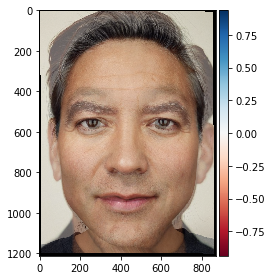

In [13]:
skio.imshow(mid_face)

In [12]:
def morph(im1, im2, im1_pts, im2_pts, tri, warp_frac, dissolve_frac):
    
    mean_pts = (warp_frac*im1_pts) + ((1-warp_frac)*im2_pts)
    
    im1_output = inverse_warp(im1, im1_pts, mean_pts, tri)
    
    im2_output = inverse_warp(im2, im2_pts, mean_pts, tri)
    
    final = (dissolve_frac * im1_output) + ((1-dissolve_frac) * im2_output)
 
    return final
    
    
def morphSequence(im1, im2, im1_pts, im2_pts, tri):
    
    output_images = []
    
    for alpha in np.arange(0.0, 1.0, 0.025):
        result = morph(im1, im2, im1_pts, im2_pts, tri, alpha, alpha)
        output_images.append(result)
        
    return output_images

In [29]:
gif_images = morphSequence(suni, sophia, suni_points, sophia_points, tri)

In [30]:
len(gif_images)

40

In [31]:
clip = ImageSequenceClip([np.clip(gif_images[i]*255, 0, 255).astype(int) for i in range(40)], fps=10)
clip.write_gif('facemorph.gif', fps=10)

MoviePy - Building file facemorph.gif with imageio.


In [32]:
# Part 3: Mean Population

In [13]:
def extract_points(filename):
        
    lines= np.arange(17, 74)
    i=0
    f = open("images/imm_face_db/" + filename, "r")
    file_contents = []
    for line in f:
        if i in lines:
            file_contents.append([line])
        i+=1

    points = []
    for line in file_contents:

        point_x = float(line[0].split("\t")[2:4][0])
        point_y = float(line[0].split("\t")[2:4][1])
        points.append((point_x*640, point_y*480))

    points.append([0, 0])
    points.append([0, 480])
    points.append([640, 0])
    points.append([640, 480])
    
    
    return points

In [14]:
directory = "images/imm_face_db"

points_all_images = []
for filename in sorted(os.listdir(directory)):
    if filename.endswith(".asf"): 
        points_all_images.append(extract_points(filename))
        continue
    else:
        continue

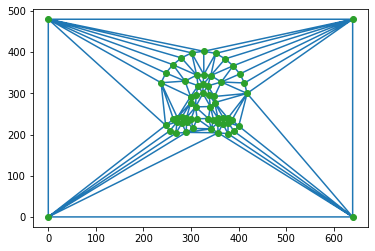

In [15]:
mean_dane = np.mean(points_all_images, axis=0)
tri_dane = Delaunay(mean_dane)
plt.triplot(mean_dane[:,0], mean_dane[:,1], tri_dane.simplices)
plt.plot(mean_dane[:,0], mean_dane[:,1], 'o')
plt.show()

In [16]:
images = []
for filename in sorted(os.listdir(directory)):
    if filename.endswith(".jpg"): 
        image = sk.img_as_float(skio.imread("images/imm_face_db/" + filename))
        images.append(image)
        continue
    else:
        continue

In [17]:
warped_images = []

for image, image_pts in zip(images, points_all_images):
    warp = inverse_warp(image, image_pts, mean_dane, tri_dane)
    warped_images.append(warp)

average_dane = np.mean(warped_images, axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


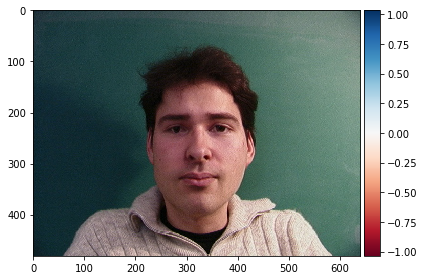

In [23]:
skio.imshow(warped_images[40])

In [40]:
imname3 = 'images/dane.png'
dane = sk.img_as_float(skio.imread(imname3))[:, :, :3]
dane = dane[0:1212,0:870]

In [41]:
%matplotlib qt
skio.imshow(dane)
dane_points = plt.ginput(n=29, timeout=90, show_clicks=True)

In [42]:
dane_points

[(247.34310302290288, 254.76034117947188),
 (446.0173475062831, 223.08763553719382),
 (661.9676132490877, 243.24299367318895),
 (759.8650670524923, 424.64121689714466),
 (774.261751435346, 568.6080607256808),
 (785.779098941629, 755.764957702778),
 (762.7444039290631, 925.6458334204508),
 (664.8469501256584, 1066.7333403724165),
 (469.05204251884885, 1155.992783546109),
 (238.70509239319068, 1058.0953297427043),
 (158.0836598492104, 919.8871596673094),
 (155.20432297263966, 758.6442945793488),
 (137.92830171321526, 606.0394401211004),
 (143.68697546635673, 447.6759119097104),
 (227.18774488690775, 603.1601032445296),
 (374.0339255920149, 600.2807663679589),
 (541.0354644331171, 603.1601032445296),
 (685.0023082616535, 594.5220926148174),
 (382.6719362217271, 781.6789895919146),
 (466.1727056422781, 738.4889364433537),
 (549.6734750628293, 778.7996527153439),
 (327.9645355668833, 919.8871596673094),
 (460.41403188913665, 891.0937909016022),
 (598.6222019645315, 922.7664965438801),
 (474

In [43]:
dane_points = np.array([(247.34310302290288, 254.76034117947188),
 (446.0173475062831, 223.08763553719382),
 (661.9676132490877, 243.24299367318895),
 (759.8650670524923, 424.64121689714466),
 (774.261751435346, 568.6080607256808),
 (785.779098941629, 755.764957702778),
 (762.7444039290631, 925.6458334204508),
 (664.8469501256584, 1066.7333403724165),
 (469.05204251884885, 1155.992783546109),
 (238.70509239319068, 1058.0953297427043),
 (158.0836598492104, 919.8871596673094),
 (155.20432297263966, 758.6442945793488),
 (137.92830171321526, 606.0394401211004),
 (143.68697546635673, 447.6759119097104),
 (227.18774488690775, 603.1601032445296),
 (374.0339255920149, 600.2807663679589),
 (541.0354644331171, 603.1601032445296),
 (685.0023082616535, 594.5220926148174),
 (382.6719362217271, 781.6789895919146),
 (466.1727056422781, 738.4889364433537),
 (549.6734750628293, 778.7996527153439),
 (327.9645355668833, 919.8871596673094),
 (460.41403188913665, 891.0937909016022),
 (598.6222019645315, 922.7664965438801),
 (474.8107162719903, 994.7499184581483),
 (11.237479144103247, 15.775380424101513),
 (849.1245102261848, 15.775380424101513),
 (852.0038471027556, 1193.4241629415283),
 (14.11681602067398, 1199.1828366946697)])

In [44]:
sophia_mean = inverse_warp(sophia, sophia_points, mean_points, tri)
dane_mean = inverse_warp(dane, dane_points, sophia_points, tri)

mid_face = sk.img_as_float((np.array(dane_mean) + np.array(sophia_mean)) / 2.0)

In [46]:
skio.imshow(dane_mean)

In [33]:
# Part 4: Caricature

In [55]:
caricature_mean = -0.5*sophia_points + 1.5*dane_points

In [58]:
# difference = sophia_mean - dane_mean
caricature = inverse_warp(sophia, sophia_points, caricature_mean, tri)

In [59]:
skio.imshow(caricature)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
